# Multilayer Perceptron (MLP) for the names dataset 

In [3]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [4]:
words = open('data/names.txt', 'r').read().split()
words[:5]

['emma', 'olivia', 'ava', 'isabella', 'sophia']

In [5]:
len(words)

32033

## Tokenization

In [6]:
chars = sorted(list(set(''.join(words))))
stringToIndex = {char:index + 1 for index, char in enumerate(chars)}
stringToIndex['.'] = 0
indexToString = {index:char for char, index in stringToIndex.items()}
print(indexToString)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [7]:
# Building the dataset
block_size = 3
X, Y = [], []
for word in words:
    # print(word)
    context = [0] * block_size
    for ch in word + '.':
        ix = stringToIndex[ch]
        X.append(context)
        Y.append(ix)
        # print(''.join(indexToString[i] for i in context), '------->', indexToString[ix])
        context = context[1:] + [ix] # Crop and append
        
X = torch.tensor(X)
Y = torch.tensor(Y)


In [8]:
# Embedding layer
C = torch.randn((27, 2))
emb = C[X]

# Weights to the hidden layer
W1 = torch.randn((6, 100))
b1 = torch.randn((100,))

## 3 ways to reshape the embedding layer

In [9]:
# Not useful, hard coded. What if my block_size changes?
torch.cat([emb[:, 0, :], emb[:, 1, :], emb[:, 2, :]], dim=1)

tensor([[-1.7030,  0.0829, -1.7030,  0.0829, -1.7030,  0.0829],
        [-1.7030,  0.0829, -1.7030,  0.0829, -0.3627,  0.1109],
        [-1.7030,  0.0829, -0.3627,  0.1109,  0.3106,  0.2517],
        ...,
        [-1.6406,  0.8209, -1.6406,  0.8209,  0.8064,  1.5305],
        [-1.6406,  0.8209,  0.8064,  1.5305, -1.6406,  0.8209],
        [ 0.8064,  1.5305, -1.6406,  0.8209, -0.1685, -0.6242]])

In [10]:
# Not efficient, we are creating another tensor
torch.cat(torch.unbind(emb, dim = 1), dim = 1)

tensor([[-1.7030,  0.0829, -1.7030,  0.0829, -1.7030,  0.0829],
        [-1.7030,  0.0829, -1.7030,  0.0829, -0.3627,  0.1109],
        [-1.7030,  0.0829, -0.3627,  0.1109,  0.3106,  0.2517],
        ...,
        [-1.6406,  0.8209, -1.6406,  0.8209,  0.8064,  1.5305],
        [-1.6406,  0.8209,  0.8064,  1.5305, -1.6406,  0.8209],
        [ 0.8064,  1.5305, -1.6406,  0.8209, -0.1685, -0.6242]])

In [11]:
# Efficient way
emb.view(-1, block_size * C.shape[1])

tensor([[-1.7030,  0.0829, -1.7030,  0.0829, -1.7030,  0.0829],
        [-1.7030,  0.0829, -1.7030,  0.0829, -0.3627,  0.1109],
        [-1.7030,  0.0829, -0.3627,  0.1109,  0.3106,  0.2517],
        ...,
        [-1.6406,  0.8209, -1.6406,  0.8209,  0.8064,  1.5305],
        [-1.6406,  0.8209,  0.8064,  1.5305, -1.6406,  0.8209],
        [ 0.8064,  1.5305, -1.6406,  0.8209, -0.1685, -0.6242]])

In [12]:
h = torch.tanh(emb.view(-1, block_size * C.shape[1])@(W1) + b1)
h.shape

torch.Size([228146, 100])

### Output layer

In [13]:
W2 = torch.randn((100, 27))
b2 = torch.randn(27)
logits = h@W2 + b2
counts = logits.exp()
prob = counts/counts.sum(1, keepdim=True)
loss = prob[torch.arange(len(Y)), Y].log().neg().mean()

In [14]:
loss

tensor(17.1074)

In [15]:
prob[torch.arange(prob.shape[0]), Y]

tensor([2.2198e-16, 1.2981e-10, 1.1093e-06,  ..., 8.6177e-01, 1.1178e-04,
        1.6722e-07])

In [16]:
prob.shape[0]

228146

# Rewriting everything:

In [17]:
g = torch.Generator().manual_seed(42)
C = torch.randn((27,2))

# Generating random parameters
W1 = torch.randn((block_size * C.shape[1], 100))
b1 = torch.randn((100,))
W2 = torch.randn((100, 27))
b2 = torch.randn(27)
params = [C, W1, b1, W2, b2]
print("number of parameters: " + str(sum(p.numel() for p in params)))
# Forward pass:

# Embedding layer
emb = C[X]

# First hidden layer
h = torch.tanh(emb.view(-1, block_size * C.shape[1])@W1 + b1)

# Output layer
logits = h@W2 + b2

# Softmax layer (We can use cross_entropy easily. But we are doing it manually)
counts = logits.exp()
prob = counts/counts.sum(1, keepdim=True)
loss = prob[torch.arange(len(Y)), Y].log().neg().mean()
print(loss.item())
# Use cross_entropy
loss2 = F.cross_entropy(logits, Y) 
print(loss2.item())

if loss.item() == loss2.item():
    print("Both losses are the same")
else:
    print("The algorithm is estimating the loss in a different way")

number of parameters: 3481
17.541959762573242
17.541959762573242
Both losses are the same


In [18]:
for p in params:
    p.requires_grad_()

In [19]:
# Forward pass:
for _ in range(100):
    # Embedding layer
    emb = C[X]

    # First hidden layer
    h = torch.tanh(emb.view(-1, block_size * C.shape[1])@W1 + b1)

    # Output layer
    logits = h@W2 + b2
    loss = F.cross_entropy(logits, Y)
    print(loss.item())
    # Backward pass
    for p in params:
        p.grad = None

    loss.backward()

    for p in params:
        # print(p.grad)
        p.data -= .2 * p.grad

17.541959762573242
14.486109733581543
12.624192237854004
11.379446029663086
10.391683578491211
9.437408447265625
8.474136352539062
7.711389541625977
7.412990570068359
6.938505172729492
6.694663047790527
6.120059490203857
5.688238620758057
5.459899425506592
5.284239768981934
5.151508331298828
5.007272243499756
4.814128398895264
4.750091075897217
4.569913864135742
4.540245532989502
4.349911689758301
4.30597448348999
4.173045635223389
4.135594844818115
4.033825397491455
3.999901056289673
3.922423839569092
3.887606620788574
3.8361716270446777
3.7925446033477783
3.774484157562256
3.7139060497283936
3.727768898010254
3.65427565574646
3.686854600906372
3.6107006072998047
3.6472930908203125
3.569866418838501
3.600708246231079
3.5299668312072754
3.555778980255127
3.491394281387329
3.512968063354492
3.452594518661499
3.472421169281006
3.4131603240966797
3.4332497119903564
3.3757691383361816
3.3975000381469727
3.340991258621216
3.3643481731414795
3.309535264968872
3.3345038890838623
3.28082299232

## Minibatch + Learning rate

In [20]:
g = torch.Generator().manual_seed(42)
C = torch.randn((27,2))

# Generating random parameters
W1 = torch.randn((block_size * C.shape[1], 100))
b1 = torch.randn((100,))
W2 = torch.randn((100, 27))
b2 = torch.randn(27)
params = [C, W1, b1, W2, b2]
print("number of parameters: " + str(sum(p.numel() for p in params)))

# Hyperparams: 
learning_rate = .5
n_epochs = 10000
batch_size = 128

for p in params:
    p.requires_grad_()
    
for _ in range(n_epochs):
    # Mini-batch construction:
    ix = torch.randint(0, X.shape[0], (batch_size,), generator=g)
    
    # Forward pass:
    # Embedding layer
    emb = C[X[ix]]

    # First hidden layer
    h = torch.tanh(emb.view(-1, block_size * C.shape[1])@W1 + b1)

    # Output layer
    logits = h@W2 + b2
    loss = F.cross_entropy(logits, Y[ix])
    # print(loss.item())
    
    # Backward pass
    for p in params:
        p.grad = None
    loss.backward()
    
    # Update
    for p in params:
        # print(p.grad)
        p.data -= learning_rate * p.grad

# Print loss with the whole dataset
# Forward pass:
# Embedding layer
emb = C[X]
h = torch.tanh(emb.view(-1, block_size * C.shape[1])@W1 + b1)
logits = h@W2 + b2
loss = F.cross_entropy(logits, Y)
print(loss.item())

number of parameters: 3481
2.3935160636901855


In [21]:
# lre = torch.linspace(-3, 0, 1000)
# lrs = 10**lre

# lri = []
# lossi = []

# for i in range(1000):
#     ix = torch.randint(0, X.shape[0], (batch_size,), generator=g)
#     emb = C[X[ix]]
#     h = torch.tanh(emb.view(-1, block_size * C.shape[1])@W1 + b1)
#     logits = h@W2 + b2
#     loss = F.cross_entropy(logits, Y[ix])
        
#     for p in params:
#         p.grad = None
#     loss.backward()
#     lr = lrs[i]
#     for p in params:
#         p.data -= lr * p.grad
    
#     lri.append(lr)
#     lossi.append(loss.item())
    
# plt.plot(lre, lossi)

## Train/dev/test split

In [22]:
# Train/dev/test split
# 80% train, 10% dev, 10% test
def build_dataset(words, block_size):
    X, Y = [], []
    for word in words:
        context = [0] * block_size
        for ch in word + '.':
            ix = stringToIndex[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix] # Crop and append
    return torch.tensor(X), torch.tensor(Y)

import random 
random.seed(42)
random.shuffle(words)
n = len(words)
train_words = words[:int(.8*n)]
dev_words = words[int(.8*n):int(.9*n)]
test_words = words[int(.9*n):]
X_train, Y_train = build_dataset(train_words, block_size)
X_dev, Y_dev = build_dataset(dev_words, block_size)
X_test, Y_test = build_dataset(test_words, block_size)

In [42]:
def multilayer_perceptron(block_size, emb_size, n_units):
    # Generating params
    # Embedding layer
    g = torch.Generator().manual_seed(42)
    C = torch.randn((27, emb_size), generator=g)
    
    # First hidden layer
    W1 = torch.randn((block_size * emb_size, n_units), generator=g)
    b1 = torch.randn((n_units,), generator=g)
    
    # Output layer
    W2 = torch.randn((n_units, 27), generator=g)
    b2 = torch.randn(27, generator=g)
    
    params = [C, W1, b1, W2, b2]
    
    return params

def forward(params, X):
    C, W1, b1, W2, b2 = params
    emb = C[X]
    h = torch.tanh(emb.view(-1, block_size * C.shape[1])@W1 + b1)
    logits = h@W2 + b2
    return logits


params = multilayer_perceptron(block_size=3, emb_size = 2, n_units = 100)
# Number of parameters
print("number of parameters: " + str(sum(p.numel() for p in params)))


number of parameters: 3481


In [45]:
def train(params, X, Y, X_dev, Y_dev, n_epochs = 1000, learning_rate = .5, batch_size = 128):
    hist_loss = []
    for p in params:
        p.requires_grad_()
    
    g = torch.Generator().manual_seed(42)
    for _ in range(n_epochs):
        # Mini-batch construction:
        ix = torch.randint(0, X.shape[0], (batch_size,), generator=g)

        # Forward pass:
        logits = forward(params, X[ix])
        loss = F.cross_entropy(logits, Y[ix])

        # Backward pass
        for p in params:
            p.grad = None
        loss.backward()
        
        # Update
        for p in params:
            p.data -= learning_rate * p.grad
        
        hist_loss.append(loss.item())
    
    # Print loss with the dev set:
    logits = forward(params, X_dev)
    dev_loss = F.cross_entropy(logits, Y_dev)
    print(dev_loss.item())
    
    return params, hist_loss
            
params, loss = train(params, X_train, Y_train, X_dev, Y_dev, n_epochs=10000, learning_rate=.4, batch_size=X_train.shape[0])

2.2393977642059326


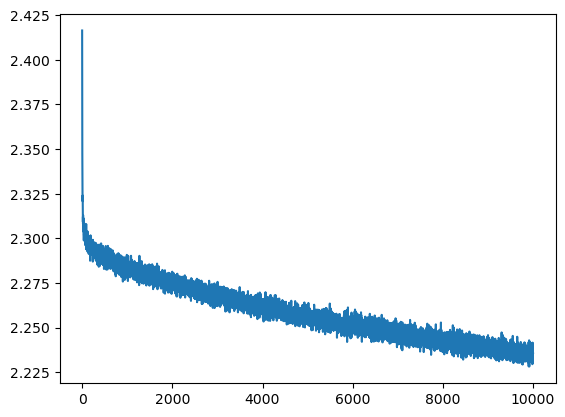

In [47]:
plt.plot(loss)